# Platoon Finding

This document aims to demonstrate the "platoon" phenomenon in a portion of the WIM data. Using years 2014-2016 in the Cereni, Denges and Gotthard stations. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style('darkgrid')
plt.rc('figure',figsize=(12,8))
plt.rc('font',size=13)
sns.set(rc={'figure.figsize':(11.7,8.27)})

C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


The function below takes an input of station name and lanes and finds the single lane platoons by comparing the timestamps of the two trucks and categorizing any trucks with timestamps of less than 3 seconds appart as in a platoon. Platoons of two or more were then combined if the headway between the last of the group is within 3 seconds. The composition of the truck types are kept and aggregated into a list. The top 5 occuring lists are then displayed for platoons of lengths 2, 3 and 4.

In [59]:
#Takes in the station and the number of the inner lanes in both directions for the period of 2014-2016
def one_lane_platoon(Station, start_y, end_y, mode, headway_seconds):
    df = pd.read_pickle('{}Data/{}_{}_datetime.pkl'.format(Station, start_y, end_y))    
    
    lanes = df.FS.unique()
    
    #For each lane in lanes, find the individual platoon histogram and most common platoon combinations
    df_platoon = []
    for lane in lanes:
        df_lane = df.loc[df['FS'] == lane]

        df_lane = df_lane.set_index('Date')
        df_lane = df_lane.sort_index()
        df_lane['HEAD_T'] =(df_lane.index.to_series().shift(-1) - df_lane.index.to_series()).dt.total_seconds() #Truck headway

        threshold_selector = df_lane.HEAD_T > headway_seconds #defines a headway of three seconds as the threshold
        groups = threshold_selector.cumsum()
        df_lane['Start']  = df_lane.index.to_series()
        df_lane['End'] = df_lane.index.to_series()
        df_lane_platoon = df_lane.groupby(groups).agg({'Start':min, 'End':max, 'CLASS': lambda x: x.tolist(), 'GW_TOT': lambda x: x.tolist(), 'LENTH': lambda x: x.tolist(), })
        df_lane_platoon['Platoon'] = (df_lane_platoon.CLASS.str.len() > 1)
        df_lane_platoon['Length'] = df_lane_platoon.CLASS.str.len()
        df_plot = df_lane_platoon[df_lane_platoon.Length > 1]
        ax = df_plot['Length'].plot.hist(bins=10, title= "{} Lane {} Platoon Frequencies Greater than 1 {}-{}".format(Station, lane, start_y, end_y)) 
        ax.set_xlabel('Number of Vehicles in Platoon')
        plt.show()
        if mode:
            #Display the combinations of platoons that are the most common for 2, 3 and 4 length
            print(df_lane_platoon[df_lane_platoon.Length == 2].CLASS.apply(tuple).value_counts().head().to_string())
            print(df_lane_platoon[df_lane_platoon.Length == 3].CLASS.apply(tuple).value_counts().head().to_string())
            print(df_lane_platoon[df_lane_platoon.Length == 4].CLASS.apply(tuple).value_counts().head().to_string())
        df_lane_platoon['Lane'] = int(lane)
        df_platoon.append(df_lane_platoon)
        
    df_platoon = pd.concat(df_platoon,ignore_index=True)
    df_platoon.to_pickle('{}Data/{}_{}_platoon_h{}.pkl'.format(Station, start_year, end_year, headway_seconds))

In [4]:
def truck_type_filter(df):
    
    overweight = list(map(str, range(41, 47)))    #List of overwieght truck classes that can be replaced to single overweight class
    medium = ['1128', '1127']
    long = ['11117', '11127', '12117']
    
    df_class = df[['Length', 'CLASS']].explode('CLASS')
    df_class['CLASS'] = df_class.CLASS.astype(str)
    df_class['CLASS'] = df_class.CLASS.replace(overweight, '41 - 46')
    df_class['CLASS'] = df_class.CLASS.replace(medium, '112r/112a')
    df_class['CLASS'] = df_class.CLASS.replace(long, '1111r/1112r/1211r')
    df_class['Length'] = df_class['Length'].apply(lambda x: str(x) if x <= 4 else '5 +')
    df_class_grouped = df_class.groupby(['Length', 'CLASS']).CLASS.count()
    df_class_grouped = df_class_grouped.unstack(-1)
    df_class_grouped = df_class_grouped.fillna(0)
    df_class_grouped = df_class_grouped.append(df_class_grouped.sum().rename('Total'))
    df_class_grouped = df_class_grouped.div(df_class_grouped.sum(1), axis=0)
    return df_class_grouped


def truck_type_graph(station, start_year, end_year, lane):
    df = pd.read_pickle('{}Data/{}_{}_platoon.pkl'.format(station, start_year, end_year))
    #First plot the entire breakdown of the classes
    if lane:
        lanes = df.Lane.unique()
        for single in lanes:
            df_lane = df.loc[df['Lane'] == single]
            df_lane = truck_type_filter(df_lane)
            f = plt.figure()
            df_lane.plot(kind='bar', stacked=True,title='{} Lane {} class breakdown depending on platoon length'.format(station, single),
                                 colormap='Set3').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
            plt.show()
            
    df_total = truck_type_filter(df)

    f = plt.figure()
    ax = df_total.plot(kind='bar', stacked=True,title='{} total class breakdown depending on platoon length'.format(station),
                         colormap='Set3').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
    plt.show()

![](StationLanes/Denges.PNG=100x20)

Below is the Denges WIM station representation.
<img src="StationLanes/Denges.PNG" width="300">

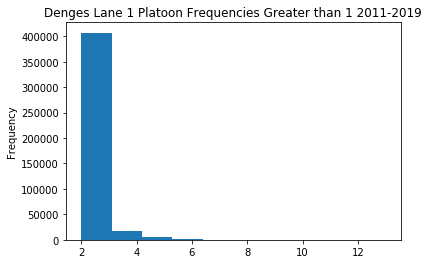

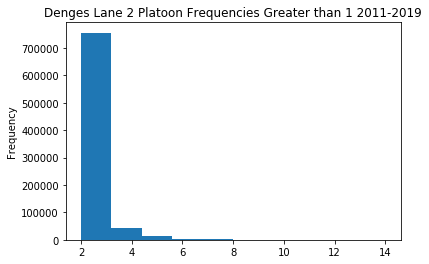

In [79]:
station = 'Denges'
df_station = one_lane_platoon(station, 2011, 2019, [1, 2], False)
df_station = pd.concat(df_station,ignore_index=True)
df_station.to_csv('{}Data/2011_2019_platoon.csv'.format(station))

In [117]:
station = "Denges"
df_station.to_pickle('{}Data/2011_2019_platoon.pkl'.format(station))

In [ ]:
station = "Denges"
df_denges = pd.read_pickle('{}Data/2011_2019_platoon.pkl'.format(station), index_col=0, parse_dates=['Start', 'End'])
df_denges.head()

In [ ]:
truck_type_graph(df_denges, True, station)

Below is the Ceneri WIM station representation.
<img src="StationLanes/Ceneri.PNG" width="300">

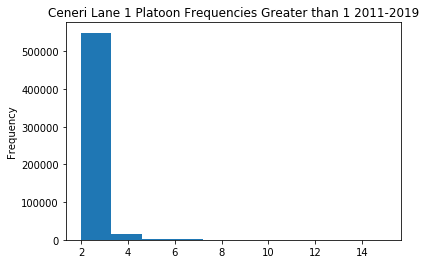

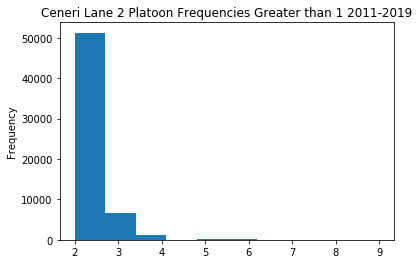

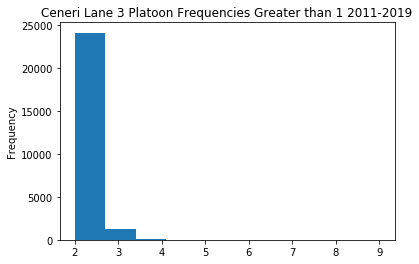

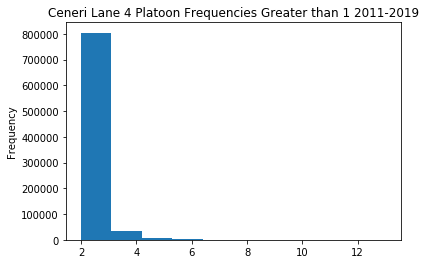

In [61]:
df_ceneri = one_lane_platoon("Ceneri", 2011, 2019, [1, 2, 3, 4], False)

In [1]:
def platoon_log_hist(station, start_year, end_year, headway_seconds):
    df = pd.read_pickle('{}Data/{}_{}_platoon_h{}.pkl'.format(station, start_year, end_year, headway_seconds))
    fig, ax = plt.subplots()
    df['Length'].plot.hist(bins =12, title= "{} Log of Natural Platoon Frequencies, {}-{}".format('Ceneri', 2011, 2019), ax=ax) 
    ax.set_xlabel('Number of vehicles in platoon')
    ax.set_yscale('log')
    plt.show()
    ax.get_figure().savefig('Figures/{}/TotalPlatoons_{}_{}.png'.format(station, start_year, end_year), bbox_inches='tight')


In [12]:
df_ceneri[df_ceneri.Length == 1].count()

Start      10114068
End        10114068
CLASS      10114068
GW_TOT     10114068
LENTH      10114068
Platoon    10114068
Length     10114068
Lane       10114068
dtype: int64

<Figure size 432x288 with 0 Axes>

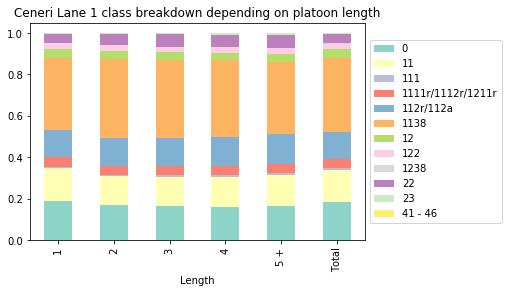

<Figure size 432x288 with 0 Axes>

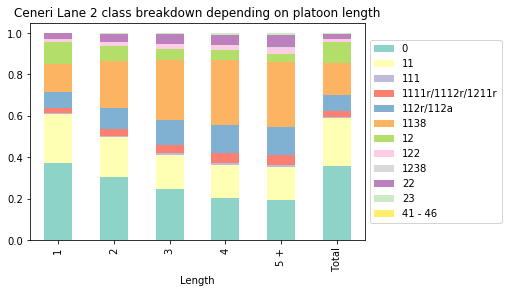

<Figure size 432x288 with 0 Axes>

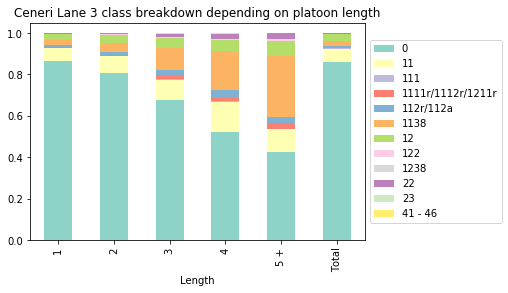

<Figure size 432x288 with 0 Axes>

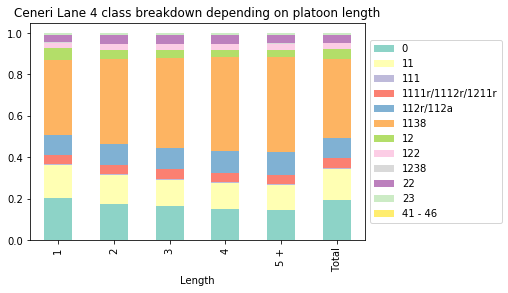

<Figure size 432x288 with 0 Axes>

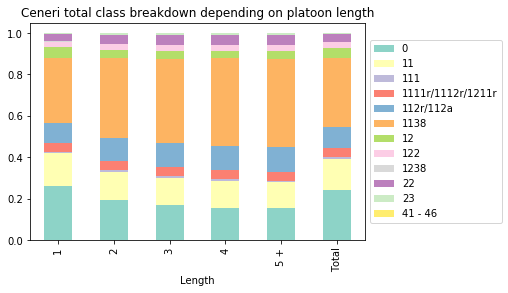

In [112]:
truck_type_graph(df_ceneri, True, station)

Below is the Gotthard WIM station representation.
<img src="StationLanes/Gotthard.PNG" width="300">

C:\Users\Isabelle\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


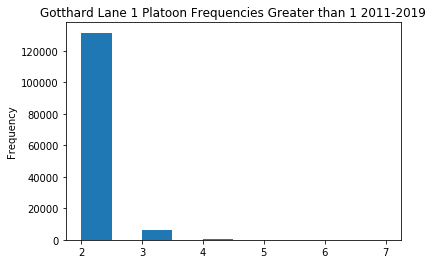

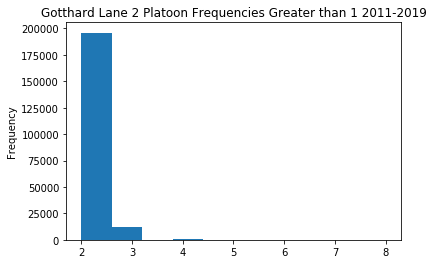

In [118]:
station = 'Gotthard'
df_station = one_lane_platoon(station, 2011, 2019, [1, 2], False)

In [120]:
df_station = pd.concat(df_station, ignore_index=True)
df_station.to_pickle('{}Data/2011_2019_platoon.pkl'.format(station))

<Figure size 432x288 with 0 Axes>

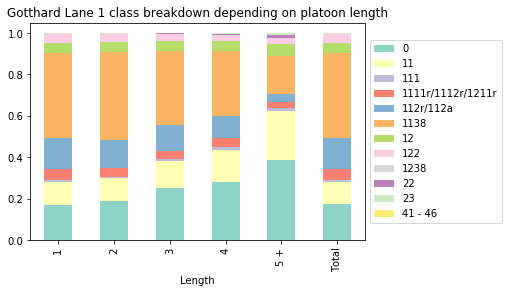

<Figure size 432x288 with 0 Axes>

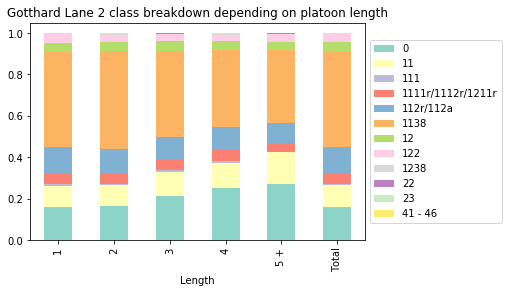

<Figure size 432x288 with 0 Axes>

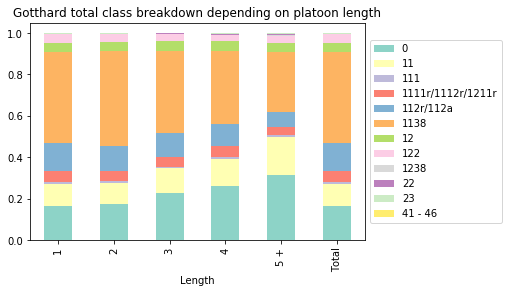

In [121]:
truck_type_graph(df_station, True, station)

## Truck natural platoon weight 

This section will show the distribution of the weight/length of each platoon using violin plots

In [5]:
def violin_weight_length(station, start_year, end_year):
    
    df_station = pd.read_pickle('{}Data/{}_{}_platoon.pkl'.format(station, start_year, end_year))
    
    df_platoon_weight = df_station[['GW_TOT', 'LENTH', 'Length', 'Lane']].explode('GW_TOT')
    df_platoon_weight = df_platoon_weight.explode('LENTH').rename(columns={'LENTH' : 'Truck Length', 'GW_TOT' : 'Total Weight'})
    df_platoon_weight['Total Weight'] = df_platoon_weight['Total Weight']/1000
    df_platoon_weight['Truck Length'] = df_platoon_weight['Truck Length']/100
    df_platoon_weight['Length'] = df_platoon_weight['Length'].apply(lambda x: str(x) if x <= 4 else '5 +')
    df_platoon_weight['Total Weight'] = pd.to_numeric(df_platoon_weight['Total Weight'], errors='coerce')
    df_platoon_weight['Truck Length'] = pd.to_numeric(df_platoon_weight['Truck Length'], errors='coerce')
    
    fig, axes = plt.subplots()
    sns.violinplot('Length', 'Total Weight', data=df_platoon_weight, ax=axes)
    axes.set_title('{} Weight Distribution by Number of Vehicles in Platoon'.format(station, start_year, end_year))

    axes.yaxis.grid(True)
    axes.set_xlabel('Number of vehicles per platoon')
    axes.set_ylabel('Vehicle weight (tons)')

    axes.get_figure().savefig('Figures/{}/{}_{}_weight_platoon.png'.format(station), bbox_inches='tight')
    
    plt.show()
    
    fig, axes = plt.subplots()
    sns.violinplot('Length', 'Truck Length', data=df_platoon_weight, ax=axes)
    axes.set_title('{} Truck Length Distribution by Number of Vehicles in Platoon'.format(station))

    axes.yaxis.grid(True)
    axes.set_xlabel('Number of vehicles per platoon')
    axes.set_ylabel('Vehicle length (meters)')
    
    axes.get_figure().savefig('Figures/{}/{}_{}_length_platoon.png'.format(station, start_year, end_year), bbox_inches='tight')

    plt.show()

In [7]:
stations = ['Ceneri', 'Denges', 'Gotthard']

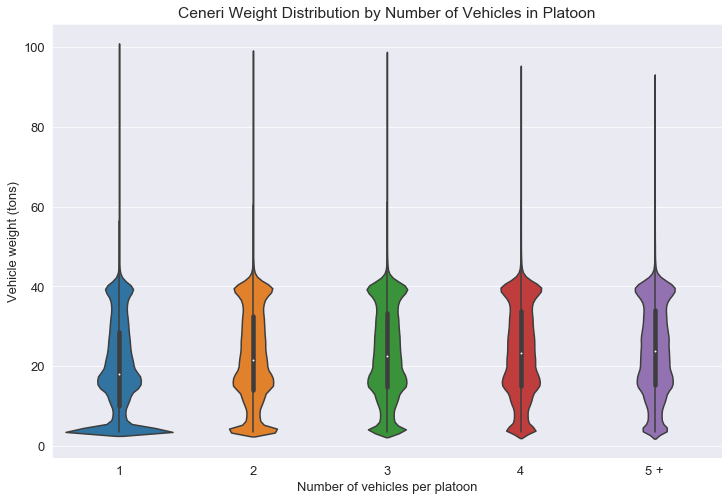

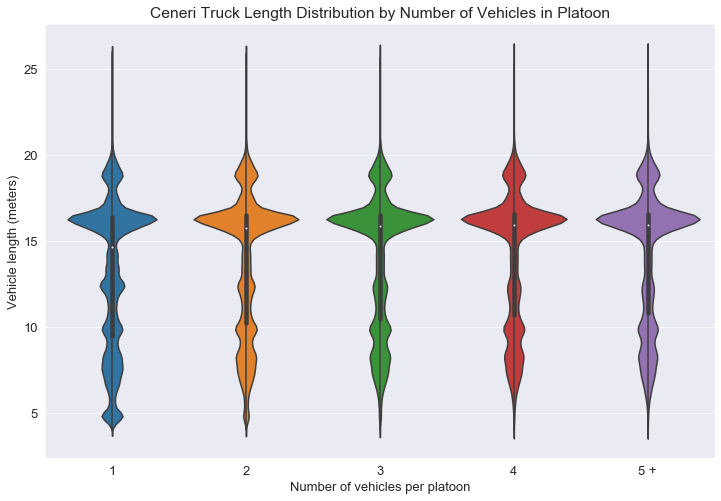

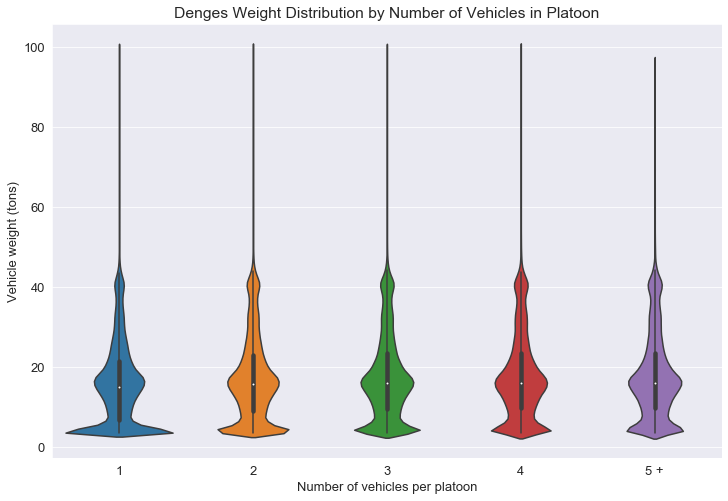

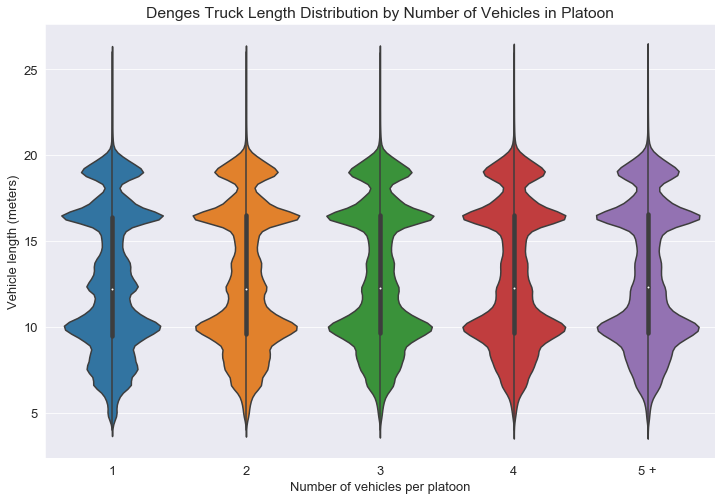

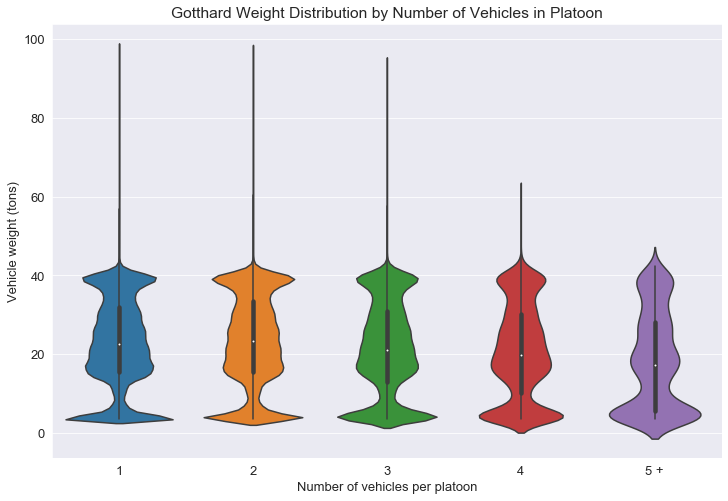

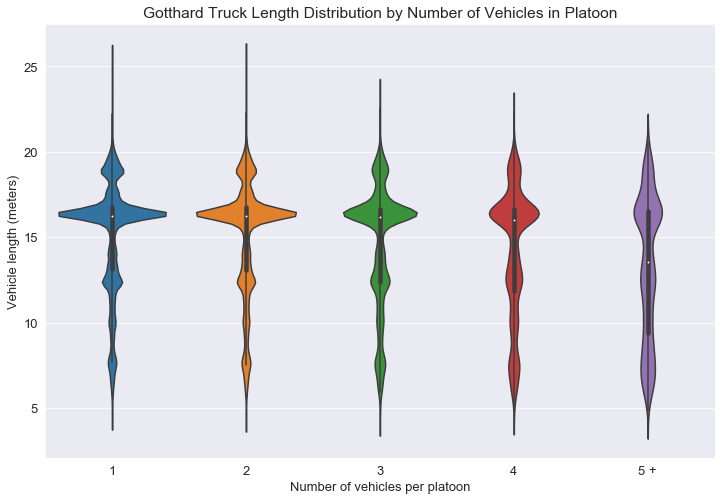

In [8]:
for station in stations:
    violin_weight_length(station)

## Platoon Finding in Circulation data

The purpose of this section is to investigate the typical headway distances using the 2017 circulation data from the 137 station, near the Ceneri WIM station. The classification of the circulation data is limited to the SWISS10 classification. In this classification there are only 6 different classifications 3 for light vehicles (< 3.5 tons) (2, 3, 4) and 3 for heavy vechicles (> 3.5 tons) (1, 5, 6).

To do this, the time difference between the heavy vehicles will be noted, with no intermediate smaller vehicles

In [2]:
station = 137
year = 2017

In [3]:
heavy = [1, 8, 9, 10]
light = range(2, 8)

In [4]:
df = pd.read_pickle('{}/{}_circ.pkl'.format(station, year))

In [13]:
df.head(10)

,z,Lane,Dir,Headway,IVT,Speed,Length,SwissT,Time,Date,index,Heavy_veh
0,0.0,5,1,99.9,99.9,109.0,384.0,3,0.020564,2017-01-01 00:01:14.003,0,False
2,0.0,5,1,13.9,13.8,112.0,379.0,3,0.024450,2017-01-01 00:01:28.002,2,False
3,0.0,5,1,0.6,0.5,115.0,448.0,3,0.024636,2017-01-01 00:01:28.069,3,False
4,0.0,5,1,7.5,7.4,116.0,426.0,3,0.026739,2017-01-01 00:01:36.026,4,False
5,0.0,1,1,33.9,33.8,86.0,446.0,3,0.026844,2017-01-01 00:01:36.064,5,False
6,0.0,5,1,14.0,13.9,101.0,448.0,3,0.030639,2017-01-01 00:01:50.030,6,False
7,0.0,5,1,0.5,0.3,102.0,749.0,4,0.030792,2017-01-01 00:01:50.085,7,False
8,0.0,5,1,5.8,5.6,99.0,422.0,3,0.032422,2017-01-01 00:01:56.072,8,False
9,0.0,5,1,1.4,1.2,98.0,383.0,3,0.032814,2017-01-01 00:01:58.013,9,False
10,0.0,1,1,47.2,47.0,100.0,473.0,3,0.039956,2017-01-01 00:02:23.084,10,False


In [6]:
df.SwissT.unique()

array([ 3,  4,  5,  2,  6, 10,  1,  8,  9,  7,  0, 17, 35, 16])

In [7]:
df.groupby('SwissT').agg({'Date': 'count'})

,Date
SwissT,
0,21
1,116872
2,544649
3,14347974
4,97786
5,2481441
6,81533
7,45669
8,410383


In [8]:
#Only having the vehicles categorized in the SWISS10 will be allowed
all_vehicles = np.concatenate((heavy, light))
df = df[df.SwissT.isin(all_vehicles)]

In [9]:
df.groupby('SwissT').agg({'Date': 'count'})

,Date
SwissT,
1,116872
2,544649
3,14347974
4,97786
5,2481441
6,81533
7,45669
8,410383
9,204580


In [10]:
df['Heavy_veh'] = df.SwissT.isin(heavy)

In [11]:
df.groupby('Heavy_veh').agg({'Date': 'count'})

,Date
Heavy_veh,
False,17599052
True,1404126


In [12]:
df = df[df.Lane.isin([1, 5])]

In [17]:
df['Adjusted_Headway'] = df['Headway'] - ((df['Length']*36)/(df['Speed']*1000))

In [36]:
df[df['IVT'] < 1].IVT.value_counts()

0.9    144941
0.8    136600
0.7    123481
0.6    106063
0.5     82545
0.4     54717
0.3     28413
0.2      9676
0.1      1816
0.0       198
Name: IVT, dtype: int64

In [21]:
df['Prev_Headway'] = df['IVT'] + df['Headway'].shift(-1)

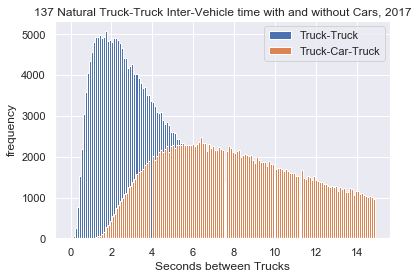

In [24]:
fig, ax = plt.subplots()

h1 = df[(df['IVT'] < 15) & df['Heavy_veh'].shift(-1) & df['Heavy_veh']].IVT.plot.hist(bins=150,title= "{} Natural Truck-Truck Headways, {}".format('137', 2017), ax=ax, label='Truck-Truck')
h2 = df[(df['Prev_Headway'] < 15) & (~df['Heavy_veh'].shift(-1).fillna(99)) & df['Heavy_veh'] & df['Heavy_veh'].shift(-2)].Prev_Headway.plot.hist(bins=150,title= "{} Natural Truck-Truck Inter-Vehicle time with and without Cars, {}".format('137', 2017), ax=ax, label='Truck-Car-Truck')
#ax.legend((h1, h2), ('Truck-Truck', 'Truck-Car-Truck'), loc='upper right', shadow=True)
ax.legend()
ax.set_xlabel('Seconds between Trucks')
ax.set_ylabel('frequency')
plt.show()